In [ ]:

!tar -xf /content/spark-3.0.0-preview2-bin-hadoop3.2.tgz.1
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark import ml , mllib

conf = SparkConf()
sc = SparkContext(conf=conf)





#####  Chargement du dataset train et test dans des dataFrames Spark avec SparkQL

In [ ]:
from pyspark import SQLContext

sqlContext = SQLContext(sc)
df = sqlContext.read.csv("./AthletesTwitterData.xls", header=True, mode="DROPMALFORMED")
test = sqlContext.read.csv("./Deflategate-DFE.xls", header=True, mode="DROPMALFORMED")


In [ ]:
test.show(5)

+---------+-------+-----------+------------------+-----------------+-----------------+----------------------------+--------------+-------------------------+----------------------+-------------------+---------------+-------------+--------------------+-----------+----------+-----------+--------------+--------------------+
| _unit_id|_golden|_unit_state|_trusted_judgments|_last_judgment_at|deflate_sentiment|deflate_sentiment:confidence|deflategate_yn|deflategate_yn:confidence|deflate_sentiment_gold|deflategate_yn_gold|           name|retweet_count|                text|tweet_coord|tweet_date|   tweet_id|tweet_location|       user_timezone|
+---------+-------+-----------+------------------+-----------------+-----------------+----------------------------+--------------+-------------------------+----------------------+-------------------+---------------+-------------+--------------------+-----------+----------+-----------+--------------+--------------------+
|663596213|  FALSE|  finalized|   

##### Présentation des schémas des tables formées 

In [ ]:
df.printSchema()

root
 |-- Player Name: string (nullable = true)
 |-- Twitter Username: string (nullable = true)
 |-- Timestamp GMT: string (nullable = true)
 |-- Twitter Text Raw: string (nullable = true)
 |-- Twitter Text after Preprocessing: string (nullable = true)
 |-- Vader Polarity Score: string (nullable = true)



In [ ]:
df.show(10)

+-----------+----------------+-------------+--------------------+--------------------------------+--------------------+
|Player Name|Twitter Username|Timestamp GMT|    Twitter Text Raw|Twitter Text after Preprocessing|Vader Polarity Score|
+-----------+----------------+-------------+--------------------+--------------------------------+--------------------+
|Karlovic I.|   <ivokarlovic>| 8/29/09 3:40| checking this th...|             checking this th...|                   0|
|Karlovic I.|   <ivokarlovic>|5/13/10 23:57| i'm still up. it...|             i'm still up. it...|                   0|
|Karlovic I.|   <ivokarlovic>|5/14/10 21:53| Just got to Zagr...|             just got to zagr...|              0.3832|
|Karlovic I.|   <ivokarlovic>|6/30/10 19:02| Practiced tennis...|             practiced tennis...|              0.4404|
|Karlovic I.|   <ivokarlovic>|6/30/10 19:48| @StephenDog I do...|             AT_USER i don't ...|              0.3565|
|Karlovic I.|   <ivokarlovic>|6/30/10 19

##### Analyse statistique 

In [ ]:
df.describe("Twitter Text Raw").show()

+-------+--------------------+
|summary|    Twitter Text Raw|
+-------+--------------------+
|  count|              124341|
|   mean|         4038263.125|
| stddev| 1.142157738761004E7|
|    min|  http://Coltonha...|
|    max|🤷🏼‍♂️ pic.twitt...|
+-------+--------------------+



Ici, il n y a que le nombre de tweet (__count__) qui represent une donnée importante. 

* Il y a 124341 tweets

##### Determination du nombre de classe  

In [ ]:
df.describe("Vader Polarity Score").show()

+-------+--------------------+
|summary|Vader Polarity Score|
+-------+--------------------+
|  count|              123667|
|   mean|  0.2733446030431471|
| stddev| 0.38316770467305017|
|    min| 'Cause lately yo...|
|    max|unbalanced on equ...|
+-------+--------------------+



In [ ]:
df.groupBy("Vader Polarity Score").count().show(40)

+--------------------+-----+
|Vader Polarity Score|count|
+--------------------+-----+
|             -0.5719|  143|
|             -0.7364|    1|
|              0.5542|   62|
|             -0.8073|    2|
|             -0.5439|    2|
|              0.7379|    2|
|               0.899|    7|
|             -0.3724|   17|
|              0.1513|   24|
|" every sport is ...|    1|
|              0.7181|    1|
|             -0.1336|    3|
|              0.3879|    1|
|               0.962|    3|
|              0.1882|    1|
|              0.7859|    3|
|              0.9031|    3|
|             -0.7121|    1|
|              -0.763|    1|
|               0.871|    2|
|              0.5378|    2|
|              0.7682|    1|
|              0.7427|    1|
|              0.6064|    1|
|              0.8679|    1|
|" girl, i know th...|    1|
|              0.7694|    1|
|              0.1201|    1|
|             -0.6997|    2|
|             -0.6187|    3|
|              0.8765|   14|
|             

On a pas que des chiffres dans les scores Vader

#### Feature Engineering

In [ ]:
from pyspark.ml.feature import Bucketizer
import numpy as np
from pyspark.sql.types import DoubleType

df2 = df.withColumn("Vader Polarity Score", df["Vader Polarity Score"].cast(DoubleType()))


In [ ]:
df2.printSchema()

root
 |-- Player Name: string (nullable = true)
 |-- Twitter Username: string (nullable = true)
 |-- Timestamp GMT: string (nullable = true)
 |-- Twitter Text Raw: string (nullable = true)
 |-- Twitter Text after Preprocessing: string (nullable = true)
 |-- Vader Polarity Score: double (nullable = true)



In [ ]:
df2.describe("Vader Polarity Score").show()

+-------+--------------------+
|summary|Vader Polarity Score|
+-------+--------------------+
|  count|              123162|
|   mean|  0.2733446030431471|
| stddev| 0.38316770467305017|
|    min|             -0.9787|
|    max|              0.9901|
+-------+--------------------+



#### Map Vader Score : 

* Sentiment score > 0.3 -> positive
* Sentiment score < -0.3 -> negative
* else neutral 


In [ ]:
from pyspark.sql.functions import when,col


df2 = df2.withColumn("Vader Polarity Score",when( col("Vader Polarity Score") < -0.3, -1).when(col("Vader Polarity Score") > 0.3, 1).otherwise(0))


In [ ]:
df2.show(5)

+-----------+----------------+-------------+--------------------+--------------------------------+--------------------+
|Player Name|Twitter Username|Timestamp GMT|    Twitter Text Raw|Twitter Text after Preprocessing|Vader Polarity Score|
+-----------+----------------+-------------+--------------------+--------------------------------+--------------------+
|Karlovic I.|   <ivokarlovic>| 8/29/09 3:40| checking this th...|             checking this th...|                   0|
|Karlovic I.|   <ivokarlovic>|5/13/10 23:57| i'm still up. it...|             i'm still up. it...|                   0|
|Karlovic I.|   <ivokarlovic>|5/14/10 21:53| Just got to Zagr...|             just got to zagr...|                   1|
|Karlovic I.|   <ivokarlovic>|6/30/10 19:02| Practiced tennis...|             practiced tennis...|                   1|
|Karlovic I.|   <ivokarlovic>|6/30/10 19:48| @StephenDog I do...|             AT_USER i don't ...|                   1|
+-----------+----------------+----------

### Bag of words Vectorization

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="Twitter Text Raw", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["twitpic","ly","bit","twitter","a","abord","absolument","afin","ah","ai","aie","aient","aies","ailleurs","ainsi","ait","allaient","allo","allons","allô","alors","anterieur","anterieure","anterieures","apres","après","as","assez","attendu","au","aucun","aucune","aucuns","aujourd","aujourd'hui","aupres","auquel","aura","aurai","auraient","aurais","aurait","auras","aurez","auriez","aurions","aurons","auront","aussi","autant","autre","autrefois","autrement","autres","autrui","aux","auxquelles","auxquels","avaient","avais","avait","avant","avec","avez","aviez","avions","avoir","avons","ayant","ayez","ayons","b","bah","bas","basee","bat","beau","beaucoup","bien","bigre","bon","boum","bravo","brrr","c","car","ce","ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci","celui-là","celà","cent","cependant","certain","certaine","certaines","certains","certes","ces","cet","cette","ceux","ceux-ci","ceux-là","chacun","chacune","chaque","cher","chers","chez","chiche","chut","chère","chères","ci","cinq","cinquantaine","cinquante","cinquantième","cinquième","clac","clic","combien","comme","comment","comparable","comparables","compris","concernant","contre","couic","crac","d","da","dans","de","debout","dedans","dehors","deja","delà","depuis","dernier","derniere","derriere","derrière","des","desormais","desquelles","desquels","dessous","dessus","deux","deuxième","deuxièmement","devant","devers","devra","devrait","different","differentes","differents","différent","différente","différentes","différents","dire","directe","directement","dit","dite","dits","divers","diverse","diverses","dix","dix-huit","dix-neuf","dix-sept","dixième","doit","doivent","donc","dont","dos","douze","douzième","dring","droite","du","duquel","durant","dès","début","désormais","e","effet","egale","egalement","egales","eh","elle","elle-même","elles","elles-mêmes","en","encore","enfin","entre","envers","environ","es","essai","est","et","etant","etc","etre","eu","eue","eues","euh","eurent","eus","eusse","eussent","eusses","eussiez","eussions","eut","eux","eux-mêmes","exactement","excepté","extenso","exterieur","eûmes","eût","eûtes","f","fais","faisaient","faisant","fait","faites","façon","feront","fi","flac","floc","fois","font","force","furent","fus","fusse","fussent","fusses","fussiez","fussions","fut","fûmes","fût","fûtes","g","gens","h","ha","haut","hein","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","hui","huit","huitième","hum","hurrah","hé","hélas","i","ici","il","ils","importe","j","je","jusqu","jusque","juste","k","l","la","laisser","laquelle","las","le","lequel","les","lesquelles","lesquels","leur","leurs","longtemps","lors","lorsque","lui","lui-meme","lui-même","là","lès","m","ma","maint","maintenant","mais","malgre","malgré","maximale","me","meme","memes","merci","mes","mien","mienne","miennes","miens","mille","mince","mine","minimale","moi","moi-meme","moi-même","moindres","moins","mon","mot","moyennant","multiple","multiples","même","mêmes","n","na","naturel","naturelle","naturelles","ne","neanmoins","necessaire","necessairement","neuf","neuvième","ni","nombreuses","nombreux","nommés","non","nos","notamment","notre","nous","nous-mêmes","nouveau","nouveaux","nul","néanmoins","nôtre","nôtres","o","oh","ohé","ollé","olé","on","ont","onze","onzième","ore","ou","ouf","ouias","oust","ouste","outre","ouvert","ouverte","ouverts","o|","où","p","paf","pan","par","parce","parfois","parle","parlent","parler","parmi","parole","parseme","partant","particulier","particulière","particulièrement","pas","passé","pendant","pense","permet","personne","personnes","peu","peut","peuvent","peux","pff","pfft","pfut","pif","pire","pièce","plein","plouf","plupart","plus","plusieurs","plutôt","possessif","possessifs","possible","possibles","pouah","pour","pourquoi","pourrais","pourrait","pouvait","prealable","precisement","premier","première","premièrement","pres","probable","probante","procedant","proche","près","psitt","pu","puis","puisque","pur","pure","q","qu","quand","quant","quant-à-soi","quanta","quarante","quatorze","quatre","quatre-vingt","quatrième","quatrièmement","que","quel","quelconque","quelle","quelles","quelqu'un","quelque","quelques","quels","qui","quiconque","quinze","quoi","quoique","r","rare","rarement","rares","relative","relativement","remarquable","rend","rendre","restant","reste","restent","restrictif","retour","revoici","revoilà","rien","s","sa","sacrebleu","sait","sans","sapristi","sauf","se","sein","seize","selon","semblable","semblaient","semble","semblent","sent","sept","septième","sera","serai","seraient","serais","serait","seras","serez","seriez","serions","serons","seront","ses","seul","seule","seulement","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soient","sois","soit","soixante","sommes","son","sont","sous","souvent","soyez","soyons","specifique","specifiques","speculatif","stop","strictement","subtiles","suffisant","suffisante","suffit","suis","suit","suivant","suivante","suivantes","suivants","suivre","sujet","superpose","sur","surtout","t","ta","tac","tandis","tant","tardive","te","tel","telle","tellement","telles","tels","tenant","tend","tenir","tente","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant","toujours","tous","tout","toute","toutefois","toutes","treize","trente","tres","trois","troisième","troisièmement","trop","très","tsoin","tsouin","tu","té","u","un","une","unes","uniformement","unique","uniques","uns","v","va","vais","valeur","vas","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan","voici","voie","voient","voilà","voire","vont","vos","votre","vous","vous-mêmes","vu","vé","vôtre","vôtres","w","x","y","z","zut","à","â","ça","ès","étaient","étais","était","étant","état","étiez","étions","été","étée","étées","étés","êtes","être","ô","s", "da", "x", "se","www","m","http","https","amp","rt","t","c","the", "to", "a", "in", "my", "ik", "com", "pic","i","s" "twitter", "status", "p","si", "de", "mbteamgl", "to","AT_USER ","a's" , "able" , "about" , "above" , "according" , "accordingly" , "across" , "actually" , "after" , "afterwards" , "again" , "against" , "ain't" , "all" , "allow" , "allows" , "almost" , "alone" , "along" , "already" , "also" , "although" , "always" , "am" , "among" , "amongst" , "an" , "and" , "another" , "any" , "anybody" , "anyhow" , "anyone" , "anything" , "anyway" , "anyways" , "anywhere" , "apart" , "appear" , "appreciate" , "appropriate" , "are" , "aren't" , "around" , "as" , "aside" , "ask" , "asking" , "associated" , "at" , "available" , "away" , "awfully" , "be" , "became" , "because" , "become" , "becomes" , "becoming" , "been" , "before" , "beforehand" , "behind" , "being" , "believe" , "below" , "beside" , "besides" , "best" , "better" , "between" , "beyond" , "both" , "brief" , "but" , "by" , "c'mon" , "c's" , "came" , "can" , "can't" , "cannot" , "cant" , "cause" , "causes" , "certain" , "certainly" , "changes" , "clearly" , "co" , "com" , "come" , "comes" , "concerning" , "consequently" , "consider" , "considering" , "contain" , "containing" , "contains" , "corresponding" , "could" , "couldn't" , "course" , "currently" , "definitely" , "described" , "despite" , "did" , "didn't" , "different" , "do" , "does" , "doesn't" , "doing" , "don't" , "done" , "down" , "downwards" , "during" , "each" , "edu" , "eg" , "eight" , "either" , "else" , "elsewhere" , "enough" , "entirely" , "especially" , "et" , "etc" , "even" , "ever" , "every" , "everybody" , "everyone" , "everything" , "everywhere" , "ex" , "exactly" , "example" , "except" , "far" , "few" , "fifth" , "first" , "five" , "followed" , "following" , "follows" , "for" , "former" , "formerly" , "forth" , "four" , "from" , "further" , "furthermore" , "get" , "gets" , "getting" , "given" , "gives" , "go" , "goes" , "going" , "gone" , "got" , "gotten" , "greetings" , "had" , "hadn't" , "happens" , "hardly" , "has" , "hasn't" , "have" , "haven't" , "having" , "he" , "he's" , "hello" , "help" , "hence" , "her" , "here" , "here's" , "hereafter" , "hereby" , "herein" , "hereupon" , "hers" , "herself" , "hi" , "him" , "himself" , "his" , "hither" , "hopefully" , "how" , "howbeit" , "however" , "i'd" , "i'll" , "i'm" , "i've" , "ie" , "if" , "ignored" , "immediate" , "in" , "inasmuch" , "inc" , "indeed" , "indicate" , "indicated" , "indicates" , "inner" , "insofar" , "instead" , "into" , "inward" , "is" , "isn't" , "it" , "it'd" , "it'll" , "it's" , "its" , "itself" , "just" , "keep" , "keeps" , "kept" , "know" , "known" , "knows" , "last" , "lately" , "later" , "latter" , "latterly" , "least" , "less" , "lest" , "let" , "let's" , "like" , "liked" , "likely" , "little" , "look" , "looking" , "looks" , "ltd" , "mainly" , "many" , "may" , "maybe" , "me" , "mean" , "meanwhile" , "merely" , "might" , "more" , "moreover" , "most" , "mostly" , "much" , "must" , "my" , "myself" , "name" , "namely" , "nd" , "near" , "nearly" , "necessary" , "need" , "needs" , "neither" , "never" , "nevertheless" , "new" , "next" , "nine" , "no" , "nobody" , "non" , "none" , "noone" , "nor" , "normally" , "not" , "nothing" , "novel" , "now" , "nowhere" , "obviously" , "of" , "off" , "often" , "oh" , "ok" , "okay" , "old" , "on" , "once" , "one" , "ones" , "only" , "onto" , "or" , "other" , "others" , "otherwise" , "ought" , "our" , "ours" , "ourselves" , "out" , "outside" , "over" , "overall" , "own" , "particular" , "particularly" , "per" , "perhaps" , "placed" , "please" , "plus" , "possible" , "presumably" , "probably" , "provides" , "que" , "quite" , "qv" , "rather" , "rd" , "re" , "really" , "reasonably" , "regarding" , "regardless" , "regards" , "relatively" , "respectively" , "right" , "said" , "same" , "saw" , "say" , "saying" , "says" , "second" , "secondly" , "see" , "seeing" , "seem" , "seemed" , "seeming" , "seems" , "seen" , "self" , "selves" , "sensible" , "sent" , "serious" , "seriously" , "seven" , "several" , "shall" , "she" , "should" , "shouldn't" , "since" , "six" , "so" , "some" , "somebody" , "somehow" , "someone" , "something" , "sometime" , "sometimes" , "somewhat" , "somewhere" , "soon" , "sorry" , "specified" , "specify" , "specifying" , "still" , "sub" , "such" , "sup" , "sure" , "t's" , "take" , "taken" , "tell" , "tends" , "th" , "than" , "thank" , "thanks" , "thanx" , "that" , "that's" , "thats" , "the" , "their" , "theirs" , "them" , "themselves" , "then" , "thence" , "there" , "there's" , "thereafter" , "thereby" , "therefore" , "therein" , "theres" , "thereupon" , "these" , "they" , "they'd" , "they'll" , "they're" , "they've" , "think" , "third" , "this" , "thorough" , "thoroughly" , "those" , "though" , "three" , "through" , "throughout" , "thru" , "thus" , "to" , "together" , "too" , "took" , "toward" , "towards" , "tried" , "tries" , "truly" , "try" , "trying" , "twice" , "two" , "un" , "under" , "unfortunately" , "unless" , "unlikely" , "until" , "unto" , "up" , "upon" , "us" , "use" , "used" , "useful" , "uses" , "using" , "usually" , "value" , "various" , "very" , "via" , "viz" , "vs" , "want" , "wants" , "was" , "wasn't" , "way" , "we" , "we'd" , "we'll" , "we're" , "we've" , "welcome" , "well" , "went" , "were" , "weren't" , "what" , "what's" , "whatever" , "when" , "whence" , "whenever" , "where" , "where's" , "whereafter" , "whereas" , "whereby" , "wherein" , "whereupon" , "wherever" , "whether" , "which" , "while" , "whither" , "who" , "who's" , "whoever" , "whole" , "whom" , "whose" , "why" , "will" , "willing" , "wish" , "with" , "within" , "without" , "won't" , "wonder" , "would" , "wouldn't" , "yes" , "yet" , "you" , "you'd" , "you'll" , "you're" , "you've" , "your" , "yours" , "yourself" , "yourselves" , "zero"]
                
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=10)

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "Vader Polarity Score", outputCol = "label")

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df2)
dataset = pipelineFit.transform(df2)
#test2 = pipelineFit()

In [ ]:
dataset.show(5)

+-----------+----------------+-------------+--------------------+--------------------------------+--------------------+--------------------+--------------------+--------------------+-----+
|Player Name|Twitter Username|Timestamp GMT|    Twitter Text Raw|Twitter Text after Preprocessing|Vader Polarity Score|               words|            filtered|            features|label|
+-----------+----------------+-------------+--------------------+--------------------------------+--------------------+--------------------+--------------------+--------------------+-----+
|Karlovic I.|   <ivokarlovic>| 8/29/09 3:40| checking this th...|             checking this th...|                   0|[checking, this, ...|   [checking, thing]|(7950,[120,2340],...|  1.0|
|Karlovic I.|   <ivokarlovic>|5/13/10 23:57| i'm still up. it...|             i'm still up. it...|                   0|[i, m, still, up,...|[2, madrid, room,...|(7950,[15,222,269...|  1.0|
|Karlovic I.|   <ivokarlovic>|5/14/10 21:53| Just got t

#### Analytics

In [ ]:
import pyspark.sql.functions as f

dataset.withColumn('mots', f.explode(f.split(f.col('Twitter Text Raw'), ' ')))\
    .groupBy('mots')\
    .count()\
    .sort('count', ascending=False)\
    .show()

+----+------+
|mots| count|
+----+------+
|    |142059|
| the| 34449|
|  to| 32924|
|   I| 25943|
|   a| 22119|
| you| 17328|
| for| 17197|
|  in| 17142|
| and| 16802|
|  my| 15117|
|  of| 12363|
|  is| 12014|
|  on| 11024|
|with|  9166|
|  :)|  7378|
|  it|  7298|
|  at|  6974|
|  be|  6860|
|this|  6201|
|  me|  5912|
+----+------+
only showing top 20 rows



In [ ]:
dataset.groupBy("label").count().show()

#### Train_test_split


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd 

dataframe = dataset.select("Vader Polarity Score","filtered","features","label").toPandas()

In [ ]:
dataframe.head()

,Vader Polarity Score,filtered,features,label
0,0,"[checking, thing]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,0,"[2, madrid, room, service, ajmo]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,1,"[zagreb, life]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
3,1,"[practiced, tennis, felt, good]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
4,1,"[stephendog, don, ace, record, back, play, dam...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.0


In [ ]:
X = dataframe[["Vader Polarity Score","filtered","features"]]
Y = dataframe["label"]
X_train, X_test, y_train, y_test=train_test_split(X,Y,stratify = Y,random_state = 100,train_size=0.70)

* Correspondance en Spark

__Evaluation des proportions__

In [ ]:
trainingData = sqlContext.createDataFrame(X_train.join(y_train))
testData = sqlContext.createDataFrame(X_test.join(y_test))


In [ ]:
### Randomly split data into training and test sets. set seed for reproducibility
#(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 87038
Test Dataset Count: 37303


In [ ]:
trainingData.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|41514|
|  1.0|40675|
|  2.0| 4849|
+-----+-----+



__5,61% de tweets negatifs, 46,54% de tweets neutres et 47,85% de tweet positifs__

In [ ]:
testData.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|17793|
|  1.0|17432|
|  2.0| 2078|
+-----+-----+



__5,54% de tweets negatifs, 46,46 de tweets neutres et 48% de tweets positifs__

In [ ]:
# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [ ]:
predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("filtered","Vader Polarity Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator.evaluate(predictions)

### Forets aléatoires

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(trainingData)
predictions_rf = rfModel.transform(testData)


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
pipeline = Pipeline(stages=[rf])
paramGrid = (ParamGridBuilder()
                            .addGrid(rf.numTrees, [10, 30])
                            .addGrid(rf.maxDepth,[5,25])
                            .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

rfModel = crossval.fit(trainingData)
predictions_rf = rfModel.transform(testData)
evaluatorrf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluatorrf.evaluate(predictions_rf)

##### Sauvegarde

In [ ]:
rfModel.bestModel.write().overwrite().save(path="ForestModelFilRouge")

##### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score

"""from pyspark.ml.tuning import CrossValidator
rfModel = CrossValidator.load("ForestModelFilRouge")"""

predictions_rf = rfModel.transform(testData)
predictions_rfDF = predictions_rf.toPandas()

y_predrf = predictions_rfDF.prediction
y_truerf= predictions_rfDF.label


f1Score = f1_score(y_truerf, y_predrf,average="macro")
precision = accuracy_score(y_pred=y_predrf,y_true=y_truerf)
print("Summary Stats")
print("Precision = %s" % precision)
#print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

##### Confusion Matrix

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabel = predictions_rf.rdd.map(lambda x: (x.prediction,x.label))
metrics = MulticlassMetrics(predictionAndLabel)

# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)


## SVM

In [ ]:
from pyspark.ml.classification import LinearSVC,OneVsRest

lsvc = LinearSVC(maxIter=10, regParam=0.1)
ovr = OneVsRest(classifier=lsvc)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")


paramGrid = (ParamGridBuilder()
             .addGrid(lsvc.regParam, [0.1, 0.3, 0.5,1]) # regularization parameter
             .addGrid(lsvc.maxIter, [5, 10, 20]) # 
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=ovr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

lsvcModel = cv.fit(trainingData)
predictions_SVM = lsvcModel.transform(testData)
evaluatorsvm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluatorsvm.evaluate(predictions_SVM)

#### Sauvegarde

In [ ]:
lsvcModel.save(path="SVMfilRougeModel")

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.tuning import CrossValidatorModel

lsvcModel = CrossValidatorModel.load("SVMfilRougeModel") 

## __Deep Learning__

__Les embeddings__

In [ ]:
from pyspark.ml.feature import Word2Vec

modelEmbbedding = Word2Vec(inputCol="filtered",outputCol="cbow",vectorSize=36)
cbow = modelEmbbedding.fit(dataset)

__Similarité entre les mots : exemple du tournoi wimbledon :__

In [ ]:
cbow.findSynonyms("wimbledon",num=5).show(5)

+-------------+------------------+
|         word|        similarity|
+-------------+------------------+
| mallorcaopen| 0.781241238117218|
|porschetennis|0.7284135818481445|
|         linz|0.7279032468795776|
|          wta|0.7122929096221924|
|    teampetra|0.7121431231498718|
+-------------+------------------+



__Recuperation du vocabulaire__

In [ ]:
vocab = cbow.getVectors().select("word")

In [ ]:
vocab.show(5)

+-----------+
|       word|
+-----------+
|   incident|
|nbcolympics|
|       buns|
|  lairdlife|
|   zaventem|
+-----------+
only showing top 5 rows



__Taille du vocabulaire__

In [ ]:
vocab.count()

14073

__Construction du modele / Import des Packages__

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re



__Vectorisation : Word2Vec__

In [ ]:
max_fatures = vocab.count() + 1
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataframe["filtered"].values)

X = tokenizer.texts_to_sequences(dataframe["filtered"].values)
X = pad_sequences(X)

In [ ]:
np.shape(X)

(124341, 36)

In [ ]:
X

array([[   0,    0,    0, ...,    0, 2290,  121],
       [   0,    0,    0, ...,  223,  943, 6063],
       [   0,    0,    0, ...,    0, 3715,   69],
       ...,
       [   0,    0,    0, ..., 4082, 8467,  606],
       [   0,    0,    0, ...,    0,    0,  847],
       [   0,    0,    0, ...,  445,  263,  439]])

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X,Y,stratify = Y,random_state = 100,train_size=0.70)

y_train = pd.get_dummies(y_train.values).values
y_test = pd.get_dummies(y_test.values).values

### __Reseaux recurrents__

In [ ]:
embed_dim = 100
lstm_out = 15

model = Sequential()
model.add(Embedding(input_dim=max_fatures, output_dim=embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 36, 100)           1407400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 36, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 15)                6960      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 48        
Total params: 1,414,408
Trainable params: 1,414,408
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
"""import pandas as pd 
import numpy as np 

Y = pd.get_dummies(donnesFiltre["label"].values).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30,stratify = Y, random_state = 100)"""

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

__Finetuning__

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train, epochs = 12, batch_size=batch_size, verbose = 1)



In [ ]:
history.params

In [ ]:
from matplotlib import pyplot as plt 

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:

score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

__confusion matrix__

In [ ]:
predictionNN = model.predict(X_test,verbose = 1)

In [ ]:
predictionNN

## __Reseaux à convolutions__

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout, MaxPooling1D
from keras.layers.embeddings import Embedding

model_cnn = Sequential()

model_cnn.add(Embedding(input_dim=max_fatures, output_dim=50,input_length = X.shape[1]))
model_cnn.add(SpatialDropout1D(0.4))
model_cnn.add(Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1))
model_cnn.add(MaxPooling1D())
model_cnn.add(LSTM(64))
#model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(3, activation='sigmoid'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 36, 50)            703700    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 36, 50)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 33, 100)           20100     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 16, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 195       
Total params: 766,235
Trainable params: 766,235
Non-trainable params: 0
_______________________________________________

In [ ]:
Xt, X_val, yt, y_val=train_test_split(X_train,y_train,stratify = y_train,random_state = 100,train_size=0.90)

history_cnn = model_cnn.fit(Xt, yt ,validation_data=(X_val,y_val), epochs=5, batch_size=32, verbose=1)
score,acc = model_cnn.evaluate(X_test, y_test, verbose = 1, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 78334 samples, validate on 8704 samples
Epoch 1/5
78334/78334 [==============================] - 69s 881us/step - loss: 0.6478 - accuracy: 0.7278 - val_loss: 0.5789 - val_accuracy: 0.7590
Epoch 2/5
78334/78334 [==============================] - 68s 869us/step - loss: 0.5421 - accuracy: 0.7790 - val_loss: 0.5700 - val_accuracy: 0.7653
Epoch 3/5
 8416/78334 [==>...........................] - ETA: 59s - loss: 0.4827 - accuracy: 0.8086

KeyboardInterrupt: ignored

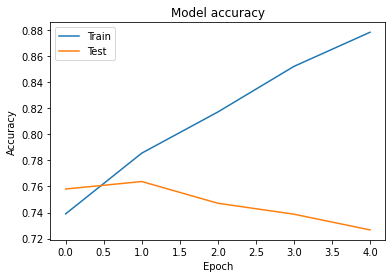

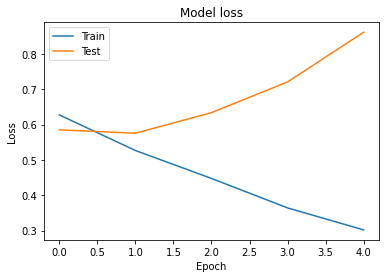

In [ ]:
from matplotlib import pyplot as plt 

# Plot training & validation accuracy values
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout, MaxPooling1D
from keras.layers.embeddings import Embedding

model_cnn = Sequential()

model_cnn.add(Embedding(input_dim=max_fatures, output_dim=50,input_length = X.shape[1]))
model_cnn.add(SpatialDropout1D(0.6))
model_cnn.add(Conv1D(filters=50, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn.add(GlobalMaxPooling1D())
"""model_cnn.add(Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))"""
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(3, activation='sigmoid'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 36, 50)            703700    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 36, 50)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 35, 50)            5050      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 195       
Total params: 712,209
Trainable params: 712,209
Non-trainable params: 0
_______________________________________________

In [ ]:
Xt, X_val, yt, y_val=train_test_split(X_train,y_train,stratify = y_train,random_state = 100,train_size=0.90)

history_cnn = model_cnn.fit(Xt, yt ,validation_data=(X_val,y_val), epochs=3, batch_size=32, verbose=1)
score,acc = model_cnn.evaluate(X_test, y_test, verbose = 1, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 78334 samples, validate on 8704 samples
Epoch 1/3
78334/78334 [==============================] - 27s 343us/step - loss: 0.6028 - accuracy: 0.7639 - val_loss: 0.5020 - val_accuracy: 0.8124
Epoch 2/3
78334/78334 [==============================] - 27s 342us/step - loss: 0.4744 - accuracy: 0.8212 - val_loss: 0.4764 - val_accuracy: 0.8153
Epoch 3/3
37303/37303 [==============================] - 2s 44us/step
score: 0.48
acc: 0.82


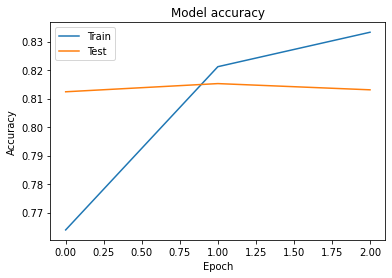

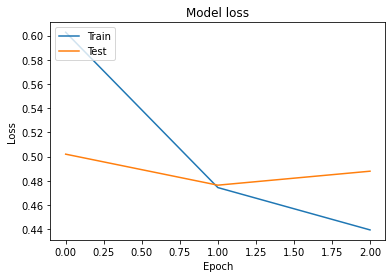

In [ ]:
from matplotlib import pyplot as plt 

# Plot training & validation accuracy values
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_cnn.evaluate(X_test, y_test, verbose = 1, batch_size = 32)

37303/37303 [==============================] - 2s 47us/step


[0.5103019002693299, 0.8133394122123718]

##### Evaluation SVM 

In [ ]:

predictions_SVM.filter(predictions_SVM['prediction'] == 0) \
    .select("label","prediction") \
    .show(n = 10, truncate = 30)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

predictions_SVM = lsvcModel.transform(testData)
predictions_SVMDF = predictions_SVM.toPandas()

y_predsvm = predictions_SVMDF.prediction
y_truesvm = predictions_SVMDF.label



In [ ]:
confusion_matrix(y_pred= y_predsvm , y_true = y_truesvm,labels=[2.0,1.0,0.0])


In [ ]:
f1Score = f1_score(y_truesvm, y_predsvm,average="macro")
precision = accuracy_score(y_pred=y_predsvm,y_true=y_truesvm)
print("Summary Stats")
print("Precision = %s" % precision)
#print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

##### Cross-Validation

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(df2)
dataset = pipelineFit.transform(df2)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

# Build the model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5,1]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluatorcv = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluatorcv.evaluate(predictions)

##### Sauvegarde de la pipeline de preprocessing

In [ ]:
#preprocessingPipeline = pipelineFit.save(path="preprocessingPipeline")

##### Sauvegarde du modele

In [ ]:
cvModel.write().overwrite().save(path="filRougeModel")

In [ ]:
cvModel = CrossValidatorModel.load(path="filRougeModel")
predictions = cvModel.transform(testData)


### Evaluation

__Rappel__

2 -> -1 (tweet negatif)

1 -> 0  (tweet neutres)

0 -> 1  (tweet positif)

__Matrice de confusion__

In [ ]:
from sklearn.metrics import confusion_matrix

predictionDF = predictions.toPandas()
y_pred = predictionDF.prediction
y_true = predictionDF.label
confusion_matrix(y_pred= y_pred , y_true = y_true,labels=[2.0,1.0,0.0])

__Evaluation quantitative : Score F1 / sensibilité / precision__

In [ ]:
from sklearn.metrics import f1_score,recall_score,accuracy_score


#precision = metrics.precision()
#recall = metrics.recall()
f1Score = f1_score(y_true, y_pred,average="macro")
precision = accuracy_score(y_true=y_true,y_pred=y_pred)
recall = recall_score(y_true=y_true,y_pred=y_pred,average="macro")

print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

__Comparaison des scores F1 pondérés au non pondérés__

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))


### Explication du modèle, Feature importance, F1-score par label

In [ ]:
cvModel.bestModel.coefficientMatrix

In [ ]:
feature_to_coef1,feature_to_coef2, feature_to_coef3 = {},{},{}
#vocabArray = pipelineFit.stages[2].vocabulary

for j in range(3):
    for f in range (cvModel.bestModel.numFeatures):
        if j == 0 :
            coef = cvModel.bestModel.coefficientMatrix[j,f]
            feature_to_coef1[vocabArray[f]] = coef
        if j == 1 :
            coef = cvModel.bestModel.coefficientMatrix[j,f]
            feature_to_coef2[vocabArray[f]] = coef 
        """if j == 2 :
            coef = cvModel.bestModel.coefficientMatrix[j,f]
            feature_to_coef3[vocabArray[f]] = coef """

##### Sauvegarde 

In [ ]:
import json

"""with open('FeatureImportanceFilRougeClass2.json', 'w') as fp:
    json.dump(feature_to_coef, fp)"""
with open('FeatureImportanceFilRougeClass0.json', 'w') as fp:
    json.dump(feature_to_coef1, fp)
with open('FeatureImportanceFilRougeClass1.json', 'w') as fp:
    json.dump(feature_to_coef2, fp)

##### Chargement 

In [ ]:
import json

with open('FeatureImportanceFilRougeClass2.json', 'r') as fp:
    feature_to_coef = json.load(fp)
with open('FeatureImportanceFilRougeClass0.json', 'r') as fp:
    feature_to_coef1=json.load(fp)
with open('FeatureImportanceFilRougeClass1.json', 'r') as fp:
    feature_to_coef2 = json.load(fp)

In [ ]:
topPositiveWord = sorted(feature_to_coef1.items(), 
                        key=lambda x: (x[1]), 
                        reverse=True)[:20]

topNegativeWord = sorted(feature_to_coef.items(), 
                        key=lambda x: (x[1]), 
                        reverse=True)[:20]

topNeutralWord = sorted(feature_to_coef2.items(), 
                        key=lambda x: (x[1]), 
                        reverse=True)[:20]


print("Les mots les plus negatifs \n")

for highest_negatives in sorted(
    feature_to_coef.items(), 
    key=lambda x: (x[1]), 
    reverse=True)[:20]:
    print (highest_negatives)

print("Les mots les plus positifs \n")
for highest_negatives in sorted(
    feature_to_coef1.items(), 
    key=lambda x: (x[1]), 
    reverse=True)[:20]:
    print (highest_negatives)
    
print("Les mots les plus neutres \n")
for highest_negatives in sorted(
    feature_to_coef2.items(), 
    key=lambda x: (x[1]), 
    reverse=True)[:20]:
    print (highest_negatives)

#### Visualisation

In [ ]:
plt.figure(figsize=(12,7))
plt.bar([x[0] for x in topPositiveWord],height=[x[1] for x in topPositiveWord])
plt.legend(["Positive Features Importance"])
plt.xticks(rotation = 60)
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
plt.bar([x[0] for x in topNegativeWord],height=[x[1] for x in topNegativeWord],color='black')
plt.legend(["Negative Features Importance"])
plt.xticks(rotation = 60)
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
plt.bar([x[0] for x in topNeutralWord],height=[x[1] for x in topNeutralWord],color='gray')
plt.legend(["Neutral Features Importance"])
plt.xticks(rotation = 60)
plt.show()

In [ ]:
from matplotlib import pyplot as plt 

customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']

#create a new figure and set the x and y limits
fig, axes = plt.subplots(figsize=(10,10))
axes.set_xlim(0.5,5.5)
axes.set_ylim(-0.5,5.5)

#loop through labels and plot each cluster
for i,h in enumerate(topPositiveWord):
    xx = plt.annotate(h[0], 
                    (h[1], 1+(i/6)),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=22,
                     color=customPalette[1])
    
for i,h in enumerate(topNegativeWord):
    xy = plt.annotate(h[0], 
                    (h[1]+3, 2+(i/6)),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=22,
                     color=customPalette[2])
    
for i,h in enumerate(topNeutralWord):
    xz = plt.annotate(h[0], 
                    (h[1]+1.5, (i/6)),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=22,
                     color=customPalette[0])
    


### Transfer Learning

In [ ]:
test.show(5)

In [ ]:
test.select("deflate_sentiment","text","deflategate_yn:confidence").show(5)

In [ ]:
sentiment = ["slightly positive","negative", "slighly negative","neutral","positive"]
test.groupBy("deflate_sentiment").count().show(100)

In [ ]:
df3 = test[test.deflate_sentiment.isin(["slightly positive","negative", "slighly negative","neutral","positive"]) == True]


In [ ]:
df3.groupBy("deflate_sentiment").count().show()

In [ ]:
df3 = df3.withColumn("deflate_sentiment",when( (col("deflate_sentiment") == "negative") | (col("deflate_sentiment") == "slighly negative"), -1)\
                     .when((col("deflate_sentiment") == "positive") | (col("deflate_sentiment") == "slighly positive"),1)\
                     .otherwise(0))


In [ ]:
df3.groupBy("deflate_sentiment").count().show()

In [ ]:
df3  = df3.select("deflate_sentiment","text","deflategate_yn:confidence")
df3 = df3.withColumnRenamed("deflate_sentiment", "Vader Polarity Score")\
       .withColumnRenamed("text", "Twitter Text Raw")

In [ ]:
df3.show(5)

#### Feature Engineering

On avait déjà developpé une pipeline de transformation en Features sur le jeu d'entrainement.

Ici, on réutilise cette pipeline pour transformé notre Dataframe de Test

In [ ]:
from pyspark.ml import Pipeline

datasetTest = pipelineFit.transform(df3)

In [ ]:
testPredictions = cvModel.transform(datasetTest)

evaluatorTest = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="f1")
evaluatorTest.evaluate(testPredictions)

In [ ]:
testPredictions.show(10)

#### Confusion Matrix

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabel = testPredictions.rdd.map(lambda x: (x.prediction,x.label))
metrics = MulticlassMetrics(predictionAndLabel)

# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)


### Approche bayésienne

In [ ]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1)
modelBayesien = nb.fit(trainingData)
predictionsBayesienne = modelBayesien.transform(testData)
predictionsBayesienne.filter(predictionsBayesienne['prediction'] == 1) \
    .select("Vader Polarity Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

In [ ]:
evaluatorcv = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluatorcv.evaluate(predictionsBayesienne)

In [ ]:
testPredictionsBay = modelBayesien.transform(datasetTest)

evaluatorTest = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="label",metricName="f1")
evaluatorTest.evaluate(testPredictionsBay)

### Streaming block

##### Connexion entre Spark et Kafka 

In [ ]:
# Subscribe to 1 topic
df = sqlContext \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "localhost:9092") \
  .option("subscribe", "Twitter") \
  .load()
df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [ ]:
import sys
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from uuid import uuid1

streaming_spark_context  = StreamingContext(sc, 5) # 2 second window
# Recuperation des tweets present dans le producer Kafka
direct_stream = KafkaUtils.createDirectStream(streaming_spark_context, ["Twitter"], {"metadata.broker.list": "localhost:9092"})

streaming_spark_context.start()
streaming_spark_context.awaitTermination()

## Topic Modelling

In [ ]:
dataset.select("features","filtered").show()

## Train LDA Model

In [ ]:
#df_training, df_testing = countVectors.randomSplit([0.9, 0.1], 1)
#df_training, df_testing = countVectors.randomSplit([1.0, 0.0], 1)
from pyspark.ml.clustering import LDA

print('Training and testing documents: ', trainingData.count(), testData.count())

numTopics = 20 # number of topics

lda = LDA(k = numTopics, seed = 1, optimizer="online", optimizeDocConcentration=True,
          maxIter = 50, # number of iterations
          learningDecay = 0.51, # kappa, learning rate
          learningOffset=64., # tau_0, a larger (positive) value downweights early iterations
          subsamplingRate = 0.05, # mini batch fraction 
          )

ldaModel = lda.fit(trainingData)
#lpt, lp = ldaModel.logPerplexity(df_testing), ldaModel.logPerplexity(df_training)
#print("Perplexity on testing and training data: " + str(lp) + ',' + str(lpt))

# Print topics and top-weighted terms
topics = ldaModel.describeTopics(maxTermsPerTopic=10)
vocabArray = pipelineFit.stages[2].vocabulary

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=numTopics)
topics.select(FormatNumbers(topics.termWeights).alias('weights')).show(truncate=False, n=numTopics)


### Sauvegarde du modele LDA

In [ ]:
# Save model
#print(ldaModel.isDistributed())
path = "./filRougePythonLDA/"

model_number = '1'
ldaModel.save(path + 'LDAModel_stem'+ model_number)
lda.save(path + 'LDA_'+ model_number)

## Top termes et Top Topic

In [ ]:
from pyspark.ml.clustering import LocalLDAModel
from pyspark.sql.types import ArrayType, StringType, FloatType, Row
from pyspark.sql.functions import udf

model_number = '1'

# load model and display topics and weights
path = "./filRougePythonLDA/"
usedLDAModel = LocalLDAModel.load("C:/Users/koffi/filRougePythonLDA/LDAModel_stem1/")
usedCVModel = pipelineFit.stages[2]

maxTermsPerTopic = 5

# Print the topics, showing the top-weighted terms for each topic.
topics = usedLDAModel.describeTopics(maxTermsPerTopic=maxTermsPerTopic)
vocabArray = usedCVModel.vocabulary
numTopics = topics.count()

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]), ArrayType(StringType()))
FormatNumbers = udf(lambda nl: [float("{:1.4f}".format(x)) for x in nl], ArrayType(FloatType()))

toptopics = topics.select((topics.topic + 1).alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words'),
                          FormatNumbers(topics.termWeights).alias('weights'))
toptopics.show(truncate=False, n=numTopics)
print('Topics:', numTopics, 'Vocabulary:', len(vocabArray))

### Visualisation de la repartion de ses topics au sein de nos documents ( tweets)

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

countVectors = (usedCVModel
                .transform(dataset.select("filtered"))
                .select("features"))

countTopDocs = (usedLDAModel
                .transform(countVectors)
                .select("topicDistribution")
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF()
                .groupBy("nTopTopic").count().sort("nTopTopic"))

pdf = countTopDocs.toPandas()
#pdfLess = pdf.drop(pdf.index[[1,3,7,8,10,11,14,15]]).reset_index()
pdfLess = pdf.reset_index()

pdfLess.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()


Il est normal que le modèle est énormement de difficultés à prédire correctement les sentiments derrière un tweet sur le jeu de données du basdket.  
En effet, on se rend compte que les topics les plus dominants ont des mots clés qui ont très peu de rapport avec ce thème. Ce sont par exemple des mots clés
tels que __Wimbledon, US Open, pour le topic 1__ ou encore __benoit Paire topic 15(joueur de tennis français)__, __même Serena Williams ( topic 6 )__

## WordCloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,4,figsize=(20, 10)) 

maxTermsPerTopic = 20
topics = usedLDAModel.describeTopics(maxTermsPerTopic=maxTermsPerTopic)
toptopics = topics.select((topics.topic + 1).alias('topic'),
                            ListOfIndexToWords(topics.termIndices).alias('words'),
                            FormatNumbers(topics.termWeights).alias('weights'))
topic_k = 1 
for k in range(1,6) :
    for j in range(1,5) :
        

        words = toptopics.collect()[topic_k-1][1]

        frequencies = toptopics.collect()[topic_k-1][2]
        #word_freq_dict = sorted(dict(zip(words,frequencies)), reverse=True)
        word_freq_dict = dict(zip(words,frequencies))

        wordcloud = WordCloud(background_color="white",
                              max_font_size=100,relative_scaling=0.5,margin=5,
                              random_state=1, stopwords=None).generate_from_frequencies(word_freq_dict)

        axarr[k-1,j-1].imshow(wordcloud)
        topic_k = topic_k  + 1



     
    

In [ ]:
toptopicsPandas = toptopics.toPandas()



In [ ]:
word_counts['excited']

In [ ]:
def format_data_to_pyldavis(df_filtered, count_vectorizer, transformed, lda_model):
    xxx = df_filtered.select((explode(df_filtered.words)).alias("word")).groupby("word").count()
    word_counts = {r['word']:r['count'] for r in xxx.collect()}
    word_counts = [word_counts[w] for w in count_vectorizer.vocabulary]


    data = {'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T, 
            'doc_topic_dists': np.array([x.toArray() for x in transformed.select(["topicDistribution"]).toPandas()['topicDistribution']]),
            'doc_lengths': [r[0] for r in df_filtered.select(size(df_filtered.words)).collect()],
            'vocab': count_vectorizer.vocabulary,
            'term_frequency': word_counts}

    return data

def filter_bad_docs(data):
    bad = 0
    doc_topic_dists_filtrado = []
    doc_lengths_filtrado = []

    for x,y in zip(data['doc_topic_dists'], data['doc_lengths']):
        if np.sum(x)==0:
            bad+=1
        elif np.sum(x) != 1:
            bad+=1
        elif np.isnan(x).any():
            bad+=1
        else:
            doc_topic_dists_filtrado.append(x)
            doc_lengths_filtrado.append(y)

    data['doc_topic_dists'] = doc_topic_dists_filtrado
    data['doc_lengths'] = doc_lengths_filtrado

In [ ]:
import pyLDAvis.gensim
from pyspark.sql.functions import udf, col, size, explode, regexp_replace, trim, lower, lit

pyLDAvis.enable_notebook()

# FORMAT DATA AND PASS IT TO PYLDAVIS
transformed = usedLDAModel.transform(trainingData)
data = format_data_to_pyldavis(dataset, usedCVModel, transformed, usedLDAModel)
filter_bad_docs(data) # this is, because for some reason some docs apears with 0 value in all the vectors, or the norm is not 1, so I filter those docs.
py_lda_prepared_data = pyLDAvis.prepare(**data)
pyLDAvis.display(py_lda_prepared_data)

In [ ]:
toptopics.show()